#OpenCV Haar Cascadesを使った顔検出
* OpenCVを使った[Haar Cascadesを使った顔検出](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html#face-detection)マニュアル
* [haarcascadesデータ](https://github.com/opencv/opencv/tree/master/data/haarcascades)
* [CascadeClassifierの種類と効果](https://symfoware.blog.fc2.com/blog-entry-1556.html)
* [Cascade Classifier Training](https://docs.opencv.org/2.4/doc/user_guide/ug_traincascade.html)

Googleドライブをマウントしておきます。

## Haar Cascadesの仕組み

Haar特徴ベースのCascade型分類器を使った物体検出はポール・ビオラ（Paul Viola）とマイケル・ジョーンズ（Michael Jones）が2001年に論文で発表しています。

この手法は機械学習を基にした手法で，正例(顔画像)と負例(顔が写っていない画像)から分類器であるcascade関数を学習します。

顔検出のために、何かしらの特徴を抽出するため、以下の画像に示すようなHaar特徴量を使います。

![代替テキスト](https://itstudio.co/sample/images/haar_features.jpg)

この特徴量はconvolutionで使うカーネルのようなものです．黒い四角形の領域に含まれる画素値の総和から白い四角形の領域に含まれる画素値の総和を引いた値がこの特徴量になります。

ところが、大量の特徴量を計算するためには、各カーネルに対してあらゆるサイズ・位置を計算します。例えば、24x24のウィンドウでさえも16万個以上の特徴量になります。

計算を簡単にするために、integral **images(積分画像)**を提案しました。

![代替テキスト](https://itstudio.co/sample/images/integral1.png)

#### 積分画像が高速な訳
![代替テキスト](https://itstudio.co/sample/images/integral2.png)



![代替テキスト](https://itstudio.co/sample/images/haar.png)


計算される大量の特徴量の大半は，実は重要ではありません。  
最初の特徴は目の辺りの領域は鼻や頬の領域に比べて暗いという性質を捉えており，二番目の特徴は目は眉間より暗いという性質を捉えるようにHaar特徴カーネルが配置されています。  
しかしながら，頬の上やそれ以外の領域に全く同じカーネルを適用しても意味がありません。それでは，どうすれば160000個以上もある特徴から最適なものを選べるのでしょうか?

この選択に Adaboost が使われます。
#### ブースティング
Adaboost はアンサンブル 学習の中のブースティングのひとつです。  
Adaboost は、弱識別器が判別を誤った訓練データは重要なので、重みを大きくすることでモデルを完成させます。一般的に弱学習器には決定木が使用される場合が多いです。

[Adaboost参考サイト](https://towardsdatascience.com/understanding-adaboost-for-decision-tree-ff8f07d2851)


### Haar Cascadesを使った顔検出のポイント
* Haar-like特徴で濃淡のパターンを見る
* Adaboostで特徴選択
* 積分画像とカスケード型分類器で高速化

### Haar分類器
Haar分類器は、オブジェクトを検出するために、 あらかじめ顔の特徴を学習させて作成した識別器をカスケードさせたものが入っているxmlファイルになっています。



## OpenCVで実装

In [0]:
from google.colab.patches import cv2_imshow #colaboratoryの場合必要
import cv2
import numpy as np

Googleドライブに用意した画像とHaarcascadesデータをカレントディレクトリにコピーしてきます。

In [0]:
cp  /content/drive/'My Drive'/images/sibling.jpg /content/drive/'My Drive'/images/haarcascade_frontalface_default.xml /content/drive/'My Drive'/images/haarcascade_eye.xml ./

画像とHaarcascadesデータの読み込み

In [0]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread('sibling.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### 関数の使い方

```
cv.CascadeClassifier.detectMultiScale(	image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]
```
パラメータ：
* image:	グレースケール（白黒）の画像データ
* scaleFactor:	スキャン毎にスケーリングされる探索窓のスケーリングファクタ（初期値1.1で1位上の値を設定）scaleFactorの値が小さいとスケールを細かく変更して検出するため、見落としは少ないが処理時間がかかる。例えば1.1ならば，探索窓が10 % 大きくなります。
* minNeighbors:	各候補長方形がそれを保持する必要がある隣接の数を指定するパラメーター。（初期値3で0以上の値を設定）様々なスケールで検出した結果、同じエリアで重複して検出される。重複した場合に真とみなすかを定義するのがminNeighbors。minNeighborsの値が小さいと重複が少ない領域も真とするため、見落としは少ないが誤検出が増える。
* flags:	関数cvHaarDetectObjectsと同じ、古いカスケードの意味を持つパラメーター。新しいカスケードには使用されません。
* minSize:	可能な最小オブジェクトサイズ。それより小さいオブジェクトは無視されます。
* maxSize:	可能な最大オブジェクトサイズ。それより大きいオブジェクトは無視されます。maxSize == minSizeモデルが単一スケールで評価される場合。


```
rectangle(Mat& img, Point pt1, Point pt2, const Scalar& color, int thickness=1, int lineType=8, int shift=0)
```

パラメータ:	
* img – 画像．
* pt1 – 矩形の1つの頂点．
* pt2 – pt1 の反対側にある矩形の頂点．
* color – 矩形の色，あるいは輝度値（グレースケール画像）．
* thickness – 矩形の枠線の太さ． CV_FILLED などの負の値の場合，塗りつぶされた矩形が描かれます．
* lineType – 枠線の種類． line() を参照してください．
* shift – 点の座標において，小数点以下の桁を表すビット数．

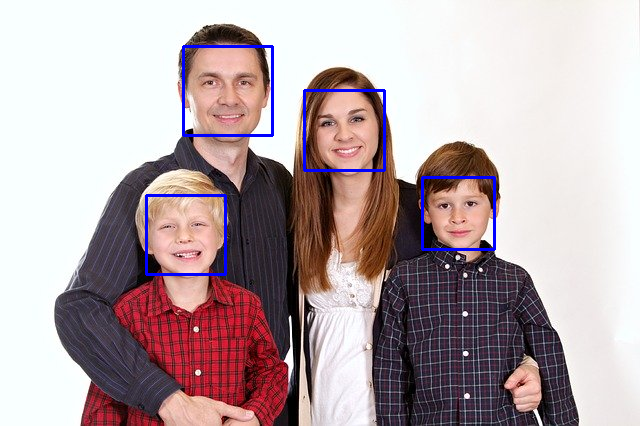

In [0]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
       
cv2_imshow(img)

In [0]:
print(x,y,w,h)
faces

146 195 79 79


array([[183,  46,  89,  89],
       [304,  90,  80,  80],
       [422, 177,  72,  72],
       [146, 195,  79,  79]], dtype=int32)

In [0]:
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

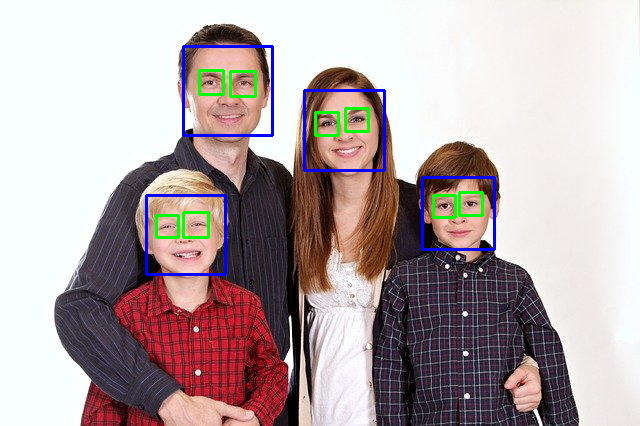

In [0]:
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w] #grayの顔の領域をスライス
    roi_color = img[y:y+h, x:x+w] #imgの顔の領域をスライス
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

cv2_imshow(img)